In [1]:
# ===========================================
# HyRA-CXR 

import os, cv2, random, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical, plot_model

# ======================
# إعدادات عامة
# ======================
base_dir   = "D://Lung X-Ray Image"   # <--  المسار
categories = ["Normal", "Lung_Opacity", "Viral_Pneumonia"]
img_size   = 224
SEED       = 42
BATCH_SIZE = 16

# بحث KerasTuner (Holdout)
KT_TRIALS           = 30      # عدد المحاولات في البحث الأولي
KT_EPOCHS_PER_TRIAL = 100      # عدد العصور لكل محاولة
REPEATS_PER_TRIAL   = 3       # إعادة نفس المعلمات 3 مرات

# 5-Fold CV
FOLDS     = 5
FT_EPOCHS = 100                 # Fine-tune داخل كل Fold

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.makedirs("outputs", exist_ok=True)

# ======================
# تحميل الصور ( )
# ======================
data, labels = [], []
for idx, category in enumerate(categories):
    cat_dir = os.path.join(base_dir, category)
    if not os.path.isdir(cat_dir):
        raise FileNotFoundError(f"Folder not found: {cat_dir}")
    for fname in os.listdir(cat_dir):
        fpath = os.path.join(cat_dir, fname)
        img = cv2.imread(fpath)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        data.append(img)
        labels.append(idx)

data   = np.array(data, dtype="float32") / 255.0
labels = np.array(labels, dtype="int32")
print(f" Loaded: {data.shape}  | Labels: {labels.shape}")




 Loaded: (3475, 224, 224, 3)  | Labels: (3475,)


In [2]:
# ======================
# دالة بناء نموذج HyRA-CXR     
# ======================
def build_hyra_cxr_hp(hp: kt.HyperParameters,
                      input_shape=(img_size, img_size, 3),
                      num_classes=len(categories)):
    # Regularization + Dropout
    l2w  = hp.Choice("l2_weight", [1e-4, 5e-5, 1e-5], default=1e-4)
    drop = hp.Float("dropout", 0.2, 0.6, step=0.1, default=0.4)

    # Filters (أصغر لتقليل الذاكرة)
    f1 = hp.Choice("filters_s1", [24, 32, 48],      default=32)
    f2 = hp.Choice("filters_s2", [48, 64, 96],      default=64)
    f3 = hp.Choice("filters_s3", [96, 128, 160],     default=128)
    head_filters = hp.Choice("head_filters", [160, 192, 256], default=192)

    # Attention toggles
    att_s2 = True
    att_s3 =True

    # Optimizer / LR
    opt_name = hp.Choice("optimizer", ["adam", "adamw", "rmsprop"], default="adam")
    # اختر أحد السطرين (الأول ثابت القيم ويتضمن 3e-4، والثاني نطاق لوغاريتمي)
    lr = hp.Choice("lr", [1e-3, 5e-4, 3e-4, 1e-4], default=3e-4)
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-3, sampling="log", default=3e-4)

    reg = regularizers.l2(l2w)

    inputs = layers.Input(shape=input_shape)

    # ---- Blocks ----
    def conv_block(x, filters, k=3, s=1):
        x = layers.Conv2D(filters, k, strides=s, padding='same', kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        return layers.ReLU()(x)

    def residual_block(x, filters):
        shortcut = x
        x = conv_block(x, filters)
        x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same', kernel_regularizer=reg)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])
        return layers.ReLU()(x)

    def attention_block(x, filters):
        # Channel attention
        w = layers.GlobalAveragePooling2D()(x)
        w = layers.Dense(max(filters // 8, 4), activation='relu')(w)
        w = layers.Dense(filters, activation='sigmoid')(w)
        x = layers.Multiply()([x, layers.Reshape((1,1,filters))(w)])
        # Spatial attention
        s = tf.reduce_mean(x, axis=-1, keepdims=True)
        s = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(s)
        return layers.Multiply()([x, s])

    # ----  ----
    x = layers.Conv2D(f1, 3, strides=2, padding='same', kernel_regularizer=reg)(inputs)  # ↓
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = residual_block(x, f1)           # يعمل الآن على 112×112
    x = layers.MaxPooling2D(2)(x)       # 56×56

    # ---- Stage 2 ----
    x = residual_block(x, f2)           # 56×56
    if att_s2:
        x = attention_block(x, f2)
    x = layers.MaxPooling2D(2)(x)       # 28×28

    # ---- Stage 3 ----
    x = residual_block(x, f3)           # 28×28
    if att_s3:
        x = attention_block(x, f3)
    x = layers.MaxPooling2D(2)(x)       # 14×14

    # ---- Head ----
    x = layers.Conv2D(head_filters, 1, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(256, activation="relu")(x)
    # ملاحظة: dtype='float32' مهم لو فعّلت mixed precision
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs, outputs, name="HyRA-CXR-HP")

    # Optimizer (مع توافق AdamW)
    lr_val = float(lr)
    if opt_name == "adamw":
        try:
            optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_val)
        except Exception:
            optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_val)
    elif opt_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_val)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_val)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [3]:
# ======================
# 80/20
# ======================
X_tr_hold, X_va_hold, y_tr_hold, y_va_hold = train_test_split(
    data, labels, test_size=0.20, random_state=SEED, stratify=labels
)
y_tr_hold_cat = to_categorical(y_tr_hold, len(categories))
y_va_hold_cat = to_categorical(y_va_hold, len(categories))
print(f" split -> Train: {X_tr_hold.shape}, Val: {X_va_hold.shape}")



 split -> Train: (2780, 224, 224, 3), Val: (695, 224, 224, 3)


In [4]:
# ======================
# KerasTuner: RandomSearch (يمكن تغييرها إلى BayesianOptimization)
# ======================
tuner = kt.RandomSearch(
    hypermodel=build_hyra_cxr_hp,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=KT_TRIALS,
    overwrite=True,
    seed=SEED,
    directory="kt_logs",
    project_name="hyra_cxr_holdout"
)


tuner.search(
    X_tr_hold, y_tr_hold_cat,
    validation_data=(X_va_hold, y_va_hold_cat),
    epochs=KT_EPOCHS_PER_TRIAL,
    batch_size=BATCH_SIZE,
    verbose=1
)



Trial 30 Complete [00h 11m 52s]
val_accuracy: 0.9151079058647156

Best val_accuracy So Far: 0.935251772403717
Total elapsed time: 07h 00m 22s
INFO:tensorflow:Oracle triggered exit


In [5]:
# تجميع نتائج كل المحاولات (trial) + المعلمات المختارة
trial_summaries = []
for trial in tuner.oracle.trials.values():
    hp_vals = trial.hyperparameters.values.copy()

    # أفضل val_acc/val_loss المسجلة داخل الـ tuner
    best_val_acc = None
    best_val_loss = None
    if "val_accuracy" in trial.metrics.metrics:
        best_val_acc = trial.metrics.get_best_value("val_accuracy")
    if "val_loss" in trial.metrics.metrics:
        best_val_loss = trial.metrics.get_best_value("val_loss")

    row = {
        "trial_id": trial.trial_id,
        "val_accuracy_best": best_val_acc,
        "val_loss_best": best_val_loss,
    }
    for k, v in hp_vals.items():
        row[f"hp_{k}"] = v
    trial_summaries.append(row)



 

In [6]:
df_trials = pd.DataFrame(trial_summaries)

# تأكد أن العمود عددي، وحوّل أي قيم غير رقمية إلى NaN
df_trials["val_accuracy_best"] = pd.to_numeric(df_trials["val_accuracy_best"], errors="coerce")

# املأ الفراغات بـ -inf بدون inplace لتفادي التحذير
df_trials["val_accuracy_best"] = df_trials["val_accuracy_best"].fillna(-np.inf)

# فرز ثم خذ نسخة صريحة (لتجنب views)
df_trials = df_trials.sort_values("val_accuracy_best", ascending=False).reset_index(drop=True).copy()

print("\nHoldout KerasTuner Trials (sorted by val_accuracy):")
print(df_trials.to_string(index=False))
df_trials.to_csv("outputs/kt_holdout_trials.csv", index=False)
print("Saved: outputs/kt_holdout_trials.csv")

# اختيار أفضل تجربة
best_trial_id = df_trials.loc[0, "trial_id"]
best_hp = tuner.oracle.trials[best_trial_id].hyperparameters
print(f"\nSelected best trial: {best_trial_id}")


Holdout KerasTuner Trials (sorted by val_accuracy):
trial_id  val_accuracy_best  val_loss_best  hp_l2_weight  hp_dropout  hp_filters_s1  hp_filters_s2  hp_filters_s3  hp_head_filters hp_optimizer  hp_lr
      24           0.935252       0.480870       0.00005         0.3             48             96            128              160      rmsprop 0.0010
      28           0.933813       0.483058       0.00010         0.3             48             48             96              192        adamw 0.0005
      08           0.932374       0.425652       0.00001         0.3             24             64            128              160        adamw 0.0010
      23           0.930935       0.499927       0.00005         0.4             48             96            160              160        adamw 0.0005
      07           0.930935       0.346502       0.00005         0.4             24             96             96              256         adam 0.0003
      21           0.929496       0.37800

In [7]:
df_trials = pd.read_csv("outputs/kt_holdout_trials.csv")

# ترتيبها من الأعلى إلى الأدنى بالدقة
df_trials = df_trials.sort_values("val_accuracy_best", ascending=False).reset_index(drop=True)

# اختيار صف التجربة الأفضل
best_trial_row = df_trials.iloc[0]
print("Best trial parameters:\n", best_trial_row)

from keras_tuner import HyperParameters

best_hp = HyperParameters()

# الآن استخرج المعلمات من الصف
best_hp.values = {
    "l2_weight": best_trial_row["hp_l2_weight"],
    "dropout": best_trial_row["hp_dropout"],
    "filters_s1": int(best_trial_row["hp_filters_s1"]),
    "filters_s2": int(best_trial_row["hp_filters_s2"]),
    "filters_s3": int(best_trial_row["hp_filters_s3"]),
    "head_filters": int(best_trial_row["hp_head_filters"]),
    "optimizer": best_trial_row["hp_optimizer"],
    "lr": float(best_trial_row["hp_lr"]),
}

print("Reconstructed best_hp:")
print(best_hp.values)


Best trial parameters:
 trial_id                   24
val_accuracy_best    0.935252
val_loss_best         0.48087
hp_l2_weight          0.00005
hp_dropout                0.3
hp_filters_s1              48
hp_filters_s2              96
hp_filters_s3             128
hp_head_filters           160
hp_optimizer          rmsprop
hp_lr                   0.001
Name: 0, dtype: object
Reconstructed best_hp:
{'l2_weight': 5e-05, 'dropout': 0.3, 'filters_s1': 48, 'filters_s2': 96, 'filters_s3': 128, 'head_filters': 160, 'optimizer': 'rmsprop', 'lr': 0.001}


In [8]:
# حفظ مخطط المعمارية الأفضل من KerasTuner
best_model_tmp = build_hyra_cxr_hp(best_hp)

import os, shutil

GRAPHVIZ_BIN = r"C:\Program Files\Graphviz\bin"  #   
os.environ["PATH"] += os.pathsep + GRAPHVIZ_BIN



from tensorflow.keras.utils import plot_model
plot_model(
    best_model_tmp,
    to_file="outputs/BestModel_from_KT.png",   #    
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=150
)
print(" Saved: outputs/BestModel_from_KT.png")

plot_model(
    best_model_tmp,
    to_file="outputs/BestModel_Compact.png",   
    show_shapes=False,
    show_layer_names=False,
    expand_nested=False,
    dpi=150
)
print(" Saved: outputs/BestModel_Compact.png")

print("\n Model Summary:")
best_model_tmp.summary(line_length=120)


 Saved: outputs/BestModel_from_KT.png
 Saved: outputs/BestModel_Compact.png

 Model Summary:
Model: "HyRA-CXR-HP"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_2 (InputLayer)                  [(None, 224, 224, 3)]      0             []                                      
                                                                                                                        
 conv2d_12 (Conv2D)                    (None, 112, 112, 48)       1344          ['input_2[0][0]']                       
                                                                                                                        
 batch_normalization_9 (BatchNormaliza  (None, 112, 112, 48)      192           ['conv2d_12[0][0]']                     
 tion)                                 

 conv2d_18 (Conv2D)                    (None, 56, 56, 1)          50            ['tf.math.reduce_mean_2[0][0]']         
                                                                                                                        
 multiply_5 (Multiply)                 (None, 56, 56, 96)         0             ['multiply_4[0][0]',                    
                                                                                 'conv2d_18[0][0]']                     
                                                                                                                        
 max_pooling2d_4 (MaxPooling2D)        (None, 28, 28, 96)         0             ['multiply_5[0][0]']                    
                                                                                                                        
 conv2d_19 (Conv2D)                    (None, 28, 28, 128)        110720        ['max_pooling2d_4[0][0]']               
                                

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.10),
], name="augment_pipeline")

def make_ds(x, y, batch, training=False, seed=42):
    # تأكيد الأنواع والشكل (one-hot)
    x = np.ascontiguousarray(x, dtype=np.float32)
    y = np.ascontiguousarray(y, dtype=np.float32)  # one-hot (N, num_classes)

    with tf.device('/CPU:0'):
        ds = tf.data.Dataset.from_tensor_slices((x, y))
        if training:
            ds = ds.shuffle(buffer_size=min(2048, len(x)), seed=seed, reshuffle_each_iteration=True)
            ds = ds.map(lambda img, lab: (augment(img, training=True), lab),
                        num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    return ds


In [10]:
def fresh_best_model(best_hp):
    """يبني نموذج HyRA-CXR من best_hp الممرّر (one-hot)."""
    return build_hyra_cxr_hp(
        best_hp,
        input_shape=(img_size, img_size, 3),
        num_classes=len(categories)
    )



================= FOLD 1/5 =================
Epoch 1/100
174/174 [==============================] - 15s 68ms/step - loss: 0.8145 - accuracy: 0.6540 - val_loss: 4.2222 - val_accuracy: 0.3165 - lr: 0.0010
Epoch 2/100
174/174 [==============================] - 11s 65ms/step - loss: 0.6175 - accuracy: 0.7622 - val_loss: 3.2278 - val_accuracy: 0.3223 - lr: 0.0010
Epoch 3/100
174/174 [==============================] - 12s 66ms/step - loss: 0.5663 - accuracy: 0.7817 - val_loss: 1.1394 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 4/100
174/174 [==============================] - 11s 66ms/step - loss: 0.5358 - accuracy: 0.7932 - val_loss: 0.4724 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 5/100
174/174 [==============================] - 12s 66ms/step - loss: 0.4977 - accuracy: 0.8097 - val_loss: 0.9826 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 6/100
173/174 [============================>.] - ETA: 0s - loss: 0.4836 - accuracy: 0.8212
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000500000023

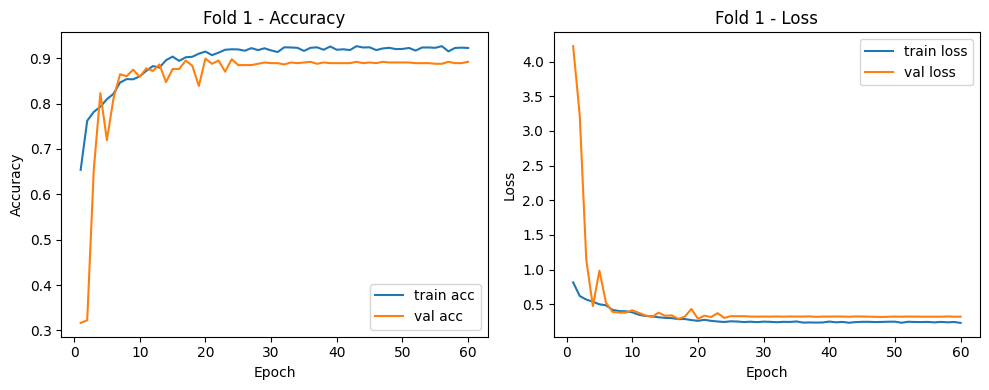

Saved: outputs/training_curves_fold1.png

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.89      0.83      0.86       250
   Lung_Opacity       0.84      0.90      0.87       225
Viral_Pneumonia       0.98      0.97      0.98       220

       accuracy                           0.90       695
      macro avg       0.90      0.90      0.90       695
   weighted avg       0.90      0.90      0.90       695



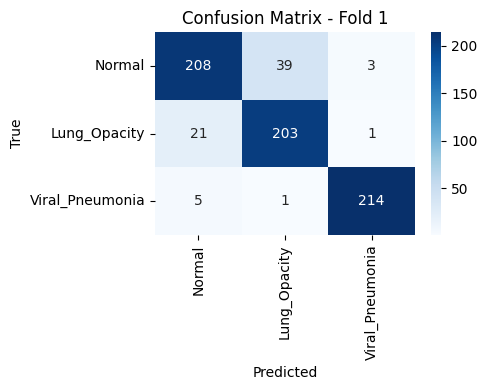

Saved: outputs/confusion_matrix_fold1.png

================= FOLD 2/5 =================
Epoch 1/100
174/174 [==============================] - 15s 68ms/step - loss: 0.7966 - accuracy: 0.6576 - val_loss: 2.0241 - val_accuracy: 0.3237 - lr: 0.0010
Epoch 2/100
174/174 [==============================] - 11s 65ms/step - loss: 0.6209 - accuracy: 0.7568 - val_loss: 1.0431 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 3/100
174/174 [==============================] - 11s 65ms/step - loss: 0.5545 - accuracy: 0.7914 - val_loss: 0.7784 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 4/100
174/174 [==============================] - 11s 66ms/step - loss: 0.5128 - accuracy: 0.8058 - val_loss: 0.4391 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 5/100
174/174 [==============================] - 11s 65ms/step - loss: 0.4943 - accuracy: 0.8122 - val_loss: 0.7812 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 6/100
173/174 [============================>.] - ETA: 0s - loss: 0.4750 - accuracy: 0.8259
Epoch 6: ReduceLROnPlatea

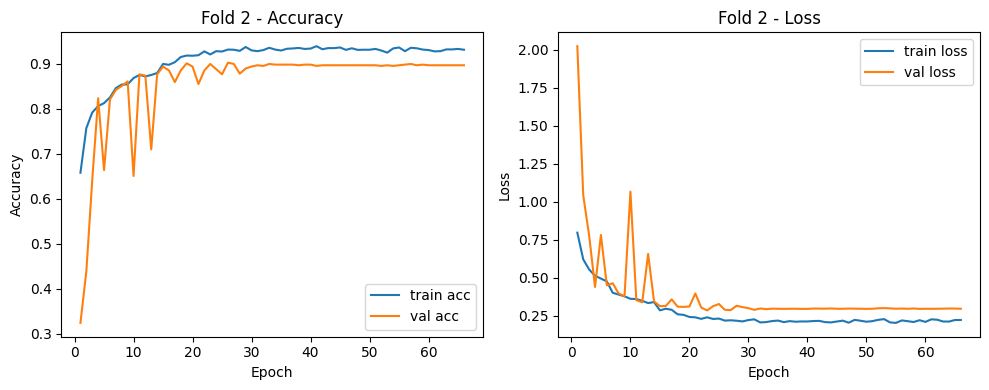

Saved: outputs/training_curves_fold2.png

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.86      0.89      0.87       250
   Lung_Opacity       0.88      0.85      0.87       225
Viral_Pneumonia       0.97      0.97      0.97       220

       accuracy                           0.90       695
      macro avg       0.90      0.90      0.90       695
   weighted avg       0.90      0.90      0.90       695



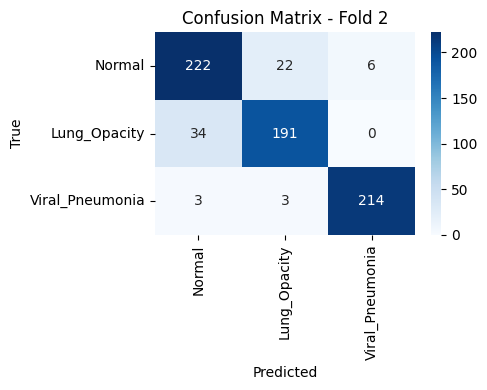

Saved: outputs/confusion_matrix_fold2.png

================= FOLD 3/5 =================
Epoch 1/100
174/174 [==============================] - 15s 68ms/step - loss: 0.8162 - accuracy: 0.6626 - val_loss: 2.5834 - val_accuracy: 0.3165 - lr: 0.0010
Epoch 2/100
174/174 [==============================] - 11s 64ms/step - loss: 0.6278 - accuracy: 0.7640 - val_loss: 1.0470 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 3/100
174/174 [==============================] - 11s 64ms/step - loss: 0.5653 - accuracy: 0.7885 - val_loss: 0.7095 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 4/100
174/174 [==============================] - 11s 65ms/step - loss: 0.5110 - accuracy: 0.8018 - val_loss: 0.5061 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/100
174/174 [==============================] - 11s 65ms/step - loss: 0.4878 - accuracy: 0.8169 - val_loss: 0.5029 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 6/100
174/174 [==============================] - 11s 65ms/step - loss: 0.4756 - accuracy: 0.8187 - val_loss: 0.6322 

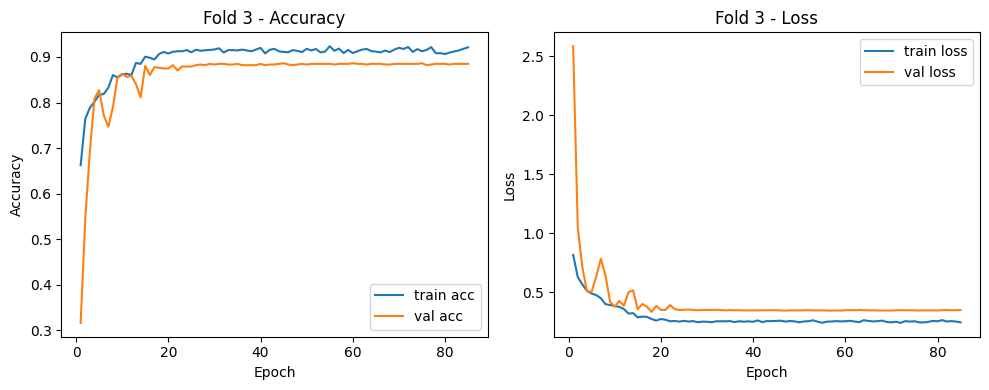

Saved: outputs/training_curves_fold3.png

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.88      0.80      0.84       250
   Lung_Opacity       0.81      0.89      0.85       225
Viral_Pneumonia       0.98      0.97      0.97       220

       accuracy                           0.89       695
      macro avg       0.89      0.89      0.89       695
   weighted avg       0.89      0.89      0.89       695



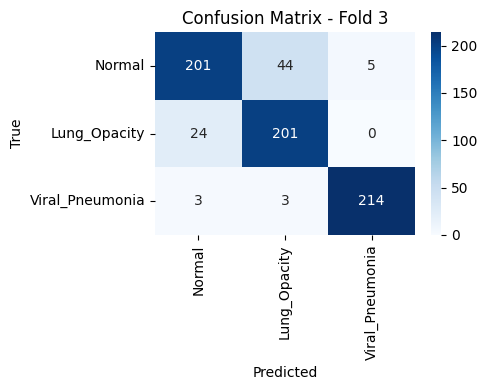

Saved: outputs/confusion_matrix_fold3.png

================= FOLD 4/5 =================
Epoch 1/100
174/174 [==============================] - 15s 70ms/step - loss: 0.8129 - accuracy: 0.6453 - val_loss: 3.3359 - val_accuracy: 0.3165 - lr: 0.0010
Epoch 2/100
174/174 [==============================] - 12s 66ms/step - loss: 0.6554 - accuracy: 0.7385 - val_loss: 0.9754 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 3/100
174/174 [==============================] - 12s 67ms/step - loss: 0.5862 - accuracy: 0.7694 - val_loss: 2.1393 - val_accuracy: 0.4345 - lr: 0.0010
Epoch 4/100
174/174 [==============================] - 12s 68ms/step - loss: 0.5532 - accuracy: 0.7784 - val_loss: 0.4763 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 5/100
174/174 [==============================] - 12s 67ms/step - loss: 0.5253 - accuracy: 0.7946 - val_loss: 0.5390 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 6/100
173/174 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.8082
Epoch 6: ReduceLROnPlatea

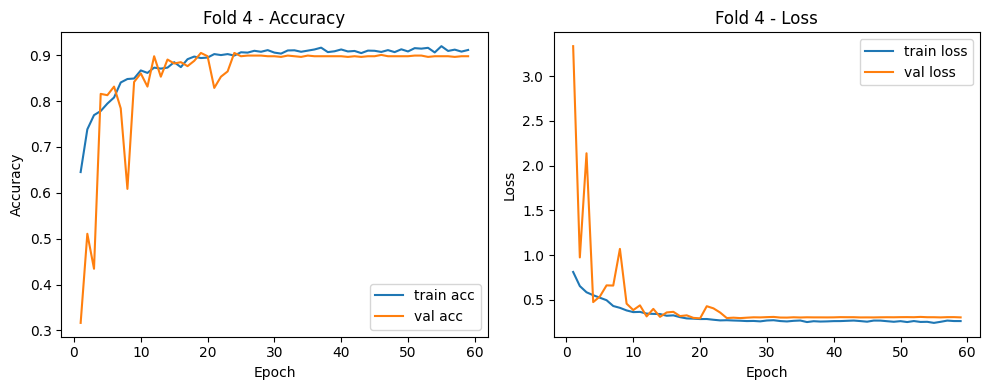

Saved: outputs/training_curves_fold4.png

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.91      0.81      0.86       250
   Lung_Opacity       0.84      0.94      0.89       225
Viral_Pneumonia       0.97      0.98      0.97       220

       accuracy                           0.91       695
      macro avg       0.91      0.91      0.91       695
   weighted avg       0.91      0.91      0.90       695



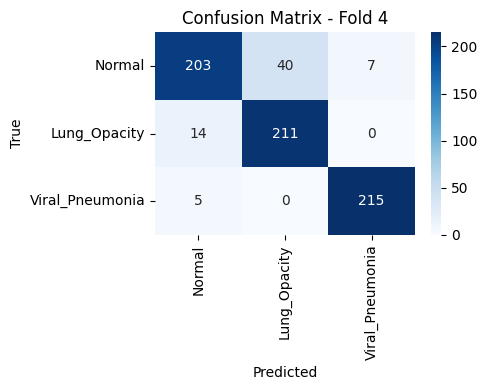

Saved: outputs/confusion_matrix_fold4.png

================= FOLD 5/5 =================
Epoch 1/100
174/174 [==============================] - 15s 69ms/step - loss: 0.8291 - accuracy: 0.6568 - val_loss: 1.9866 - val_accuracy: 0.3165 - lr: 0.0010
Epoch 2/100
174/174 [==============================] - 12s 66ms/step - loss: 0.6154 - accuracy: 0.7619 - val_loss: 1.7119 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 3/100
174/174 [==============================] - 12s 66ms/step - loss: 0.5484 - accuracy: 0.7942 - val_loss: 0.5472 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 4/100
174/174 [==============================] - 12s 67ms/step - loss: 0.5290 - accuracy: 0.7975 - val_loss: 0.7371 - val_accuracy: 0.7338 - lr: 0.0010
Epoch 5/100
174/174 [==============================] - 12s 67ms/step - loss: 0.4975 - accuracy: 0.8072 - val_loss: 0.5193 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/100
174/174 [==============================] - 12s 67ms/step - loss: 0.4762 - accuracy: 0.8176 - val_loss: 0.5074 

Epoch 43/100
174/174 [==============================] - 12s 68ms/step - loss: 0.1995 - accuracy: 0.9410 - val_loss: 0.2223 - val_accuracy: 0.9194 - lr: 1.9531e-06
Epoch 44/100
173/174 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9310
Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.
174/174 [==============================] - 12s 68ms/step - loss: 0.2190 - accuracy: 0.9313 - val_loss: 0.2217 - val_accuracy: 0.9223 - lr: 1.9531e-06
Epoch 45/100
174/174 [==============================] - 12s 68ms/step - loss: 0.2036 - accuracy: 0.9353 - val_loss: 0.2216 - val_accuracy: 0.9237 - lr: 1.0000e-06
Epoch 46/100
174/174 [==============================] - 12s 68ms/step - loss: 0.2003 - accuracy: 0.9327 - val_loss: 0.2215 - val_accuracy: 0.9237 - lr: 1.0000e-06
Epoch 47/100
174/174 [==============================] - 12s 68ms/step - loss: 0.1996 - accuracy: 0.9324 - val_loss: 0.2221 - val_accuracy: 0.9237 - lr: 1.0000e-06
Epoch 48/100
174/174 [=================

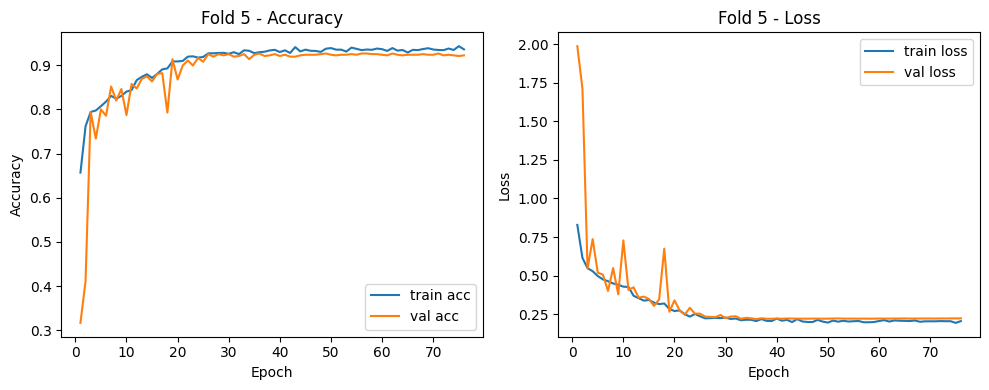

Saved: outputs/training_curves_fold5.png

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.89      0.91      0.90       250
   Lung_Opacity       0.90      0.90      0.90       225
Viral_Pneumonia       0.99      0.97      0.98       220

       accuracy                           0.93       695
      macro avg       0.93      0.93      0.93       695
   weighted avg       0.93      0.93      0.93       695



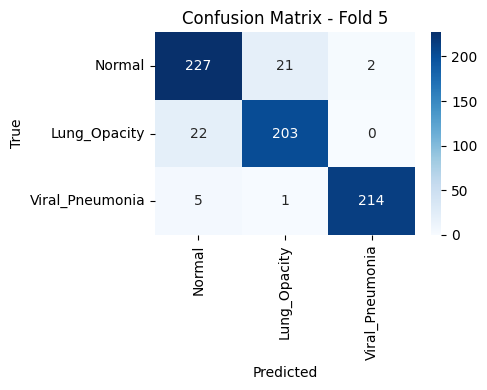

Saved: outputs/confusion_matrix_fold5.png

================= CV SUMMARY =================
Accuracies per fold (%): ['89.93', '90.22', '88.63', '90.50', '92.66']
Mean Accuracy: 90.39%   ±   Std: 1.30%

Artifacts saved in ./outputs :
- kt_holdout_trials.csv (نتائج كل محاولات KerasTuner على 80/20)
- BestModel_from_KT.png (مخطط المعمارية المختارة)
- training_history_fold*.csv + training_curves_fold*.png
- classification_report_fold*.csv
- confusion_matrix_fold*.png


In [11]:
# ======================
# 5-Fold CV باستخدام المعمارية الأفضل
# ======================
import gc



y_all_cat = to_categorical(labels, len(categories)).astype('float32')
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(data, labels), start=1):
    print(f"\n================= FOLD {fold}/{FOLDS} =================")
    X_tr, X_va = data[tr_idx], data[va_idx]
    y_tr, y_va = y_all_cat[tr_idx], y_all_cat[va_idx]

    ds_train = make_ds(X_tr, y_tr,BATCH_SIZE, training=True ,  seed=SEED)   # Aug على التدريب فقط
    ds_val   = make_ds(X_va, y_va,BATCH_SIZE, training=False,  seed=SEED)
    
    tf.keras.backend.clear_session(); gc.collect()

    model = fresh_best_model(best_hp)
    
    cb_es  = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
    cb_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

    history = model.fit(
        ds_train,
        epochs=FT_EPOCHS,
        validation_data=ds_val,
        verbose=1,
        callbacks=[cb_es, cb_rlr]
    )

    # تقييم
    val_loss, val_acc = model.evaluate(ds_val, verbose=0)
    print(f"Fold-{fold} Accuracy: {val_acc*100:.2f}%")
    fold_scores.append(val_acc * 100)

    # منحنيات التدريب
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(f"outputs/training_history_fold{fold}.csv", index=False)
    epochs_r = range(1, len(hist_df.get('loss', [])) + 1)
    plt.figure(figsize=(10,4))
    # Acc
    plt.subplot(1,2,1)
    plt.plot(epochs_r, hist_df.get('accuracy', []), label='train acc')
    plt.plot(epochs_r, hist_df.get('val_accuracy', []), label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Fold {fold} - Accuracy'); plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_r, hist_df.get('loss', []), label='train loss')
    plt.plot(epochs_r, hist_df.get('val_loss', []), label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Fold {fold} - Loss'); plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/training_curves_fold{fold}.png", dpi=150)
    plt.show()
    print(f"Saved: outputs/training_curves_fold{fold}.png")

    # تقرير تصنيفي + مصفوفة الالتباس
    y_true, y_pred = [], []
    for xb, yb in ds_val:
        preds = model.predict(xb, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(yb.numpy(), axis=1))

    print("\nClassification Report:")
    rep_txt = classification_report(y_true, y_pred, target_names=categories)
    print(rep_txt)
    # حفظ التقرير كـ CSV أيضًا
    rep_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=categories, output_dict=True)).transpose()
    rep_df.to_csv(f"outputs/classification_report_fold{fold}.csv")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories)
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"outputs/confusion_matrix_fold{fold}.png", dpi=150)
    plt.show()
    print(f"Saved: outputs/confusion_matrix_fold{fold}.png")

    # (اختياري) تفريغ الجلسة لتقليل الذاكرة قبل الفولد التالي
    tf.keras.backend.clear_session()
    gc.collect()

# ملخص
print("\n================= CV SUMMARY =================")
print("Accuracies per fold (%):", [f"{s:.2f}" for s in fold_scores])
print(f"Mean Accuracy: {np.mean(fold_scores):.2f}%   ±   Std: {np.std(fold_scores):.2f}%")

print("\nArtifacts saved in ./outputs :")
print("- kt_holdout_trials.csv (نتائج كل محاولات KerasTuner على 80/20)")
print("- BestModel_from_KT.png (مخطط المعمارية المختارة)")
print("- training_history_fold*.csv + training_curves_fold*.png")
print("- classification_report_fold*.csv")
print("- confusion_matrix_fold*.png")


In [12]:
model = fresh_best_model(best_hp) 

